# 90-general-metrics-evaluation
> Code for streamlining generation of confusion matrix and metrics

Here, we generate some functions to make sure that metrics can be computed easily and consistently across model runs.

In [ ]:
#all_no_test
#default_exp performance_metrics

In [ ]:
#export
#Data analysis and processing
import pandas as pd

#Plotting functions
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
#Import Zeroshot Pipeline for Unit Test
from transformers import pipeline

# Generalized function development
Here, we develop two functions to help us with:
* Converting zero shot results (list of dictionaries) to a dataframe
* Pretty-printing a confusion matrix based on zero-shot results

To see the original development of this code for more nuanced understanding of each line, explore the 60 notebook series at commit [8fc13e63a](https://github.com/vanderbilt-data-science/wise/commit/8fc13e63a88941eed87f4dab868108e6012019d2). 

In [ ]:
#export
def zsresults_to_df(csv_df, zeroshot_results, labels_rename):
    '''
    Function zsresults_to_df: Converts HF zero-shot pipeline outputs to a dataframe
    Inputs: csv_df: pandas dataframe with continuous index and at least columns label and speech
            zeroshot_results: output of HF zeroshot classification (list of dictionaries)
            labels_rename: dictionary with keys corresponding to labels in the data and values corresponding
                to zero-shot label "nicknames" (e.g., one element would be 'PRS':'praise')
    Returns: a dataframe of the results, with new columns 'pred_zslabels' - pipeline predictions as "nicknames",
            'pred' - pipeline predictions as the original data labels
            'truth' - ground truth from csv_df
            'sequence' - csv_df 'speech' column used for checking correctness of merge
            columns corresponding to each "nickname" label filled with pipeline inference probabilities.
            Each row is 1:1 with csv_df.
    '''
    
    #Separate out the labels given in the data vs the zeroshot nicknames we gave them
    data_labels, label_nicknames = [list(el) for el in zip(*labels_rename.items())]
    nicknames_to_labels = dict(zip(label_nicknames, data_labels))
    
    #Parse through zeroshot_results to make a list of dataframes
    results_df_list = [pd.DataFrame(result) for result in zeroshot_results]
    
    #Add back original indices to make sure concatenation works correctly
    csv_df = csv_df.reset_index().rename(columns={'index':'sample_id'})
    results_df_list = [df.assign(sample_id = ind) for ind, df in enumerate(results_df_list)]
    
    #Concatenate all dataframes the list into a single dataframe
    results_df = pd.concat(results_df_list)
    
    #Pivot the column of labels and probabilities to be a single row per sample (long to wide)
    results_df = results_df.pivot(index=['sample_id', 'sequence'], columns='labels', values='scores').reset_index(level='sequence')
    results_df['pred_zslabels'] = results_df[label_nicknames].idxmax(axis=1)
    
    #Substitute zero-shot names with real (in the data) label names
    results_df['pred'] = results_df['pred_zslabels'].replace(nicknames_to_labels)
    
    #Merge results table with original csv to get original labels
    results_df = results_df.merge(csv_df[['sample_id', 'label', 'speech']], left_index=True, right_on='sample_id')
    
    #Fix label weirdness (remove unwanted spaces in labels)
    results_df['label'] = results_df['label'].str.strip()
    
    #Specify the true label as "truth"
    results_df = results_df.rename(columns={'label':'truth'})
    
    return results_df

In [ ]:
#export
def get_performance_metrics(truth_vec, preds_vec, labels_rename, show_plots=False):
    '''
    Function get_performance_metrics: Returns performance metrics for classification
    Inputs: truth_vec: pandas series or numpy array corresponding with ground truth "data" labels
            preds_vec: pandas series or numpy array corresponding to the predicted "data" labels
            labels_rename: dictionary of "data labels":nicknames (e.g., {'PRS':'praise'}) or
                           list of true labels (e.g., ['PRS', 'REP'])
            show_plots (default False): if True, shows pretty confusion matrix and classification report
    Returns: dataframe of confusion matrix, dataframe of classification report
    '''
    
    #determine type of labels_rename_lookup to determine action
    #this allows us to use the same function for zero-shot classification and regular classification
    if isinstance(labels_rename, list):
        labels_rename = dict(zip(labels_rename, labels_rename))
    
    #get the different elements
    data_labels, label_nicknames = [list(el) for el in zip(*labels_rename.items())]
    
    #Create confusion matrix using sklearn
    c_ma = confusion_matrix(truth_vec, preds_vec, labels=data_labels)
    
    #Create confusion matrix as dataframe
    c_df = pd.DataFrame(c_ma,
                        columns = data_labels,
                        index = data_labels)
    c_df.rename(columns=labels_rename, index=labels_rename, inplace=True)
    c_df.index.name = 'Actual Labels'
    c_df.columns.name = 'Predicted Labels'
    
    #Get classification report as dataframe
    perf_metrics = classification_report(truth_vec, preds_vec,
                                         labels=data_labels, target_names = label_nicknames,
                                         output_dict=True)
    perf_metrics = pd.DataFrame(perf_metrics)
    
    #Show formatted confusion matrix
    if show_plots:
        print('Classification Report:')
        ax = sns.heatmap(c_df, cmap='Blues', annot=True, fmt='d');
        ax.set_xticklabels(ax.get_xticklabels(),rotation = 45);
        ax.set_yticklabels(ax.get_yticklabels(),rotation = 45);
        ax.set_title('Confusion Matrix')
        print(classification_report(truth_vec, preds_vec, labels=data_labels, target_names = label_nicknames))
    
    return c_df, perf_metrics

# Unit test
Let's just quickly make sure that this is working correctly. First, we'll make a fake dataframe with all of the relevant columns that we want.

In [ ]:
sample_data = {'label':['NEU', 'PRS', 'NEU', 'REP', 'NEU', 'OTR', 'NEU'],
               'speech': ['The dog is super cute!',
                          'That was a great job that you did!',
                          'The universe exists.',
                          'You should not be talking while the teacher is talking.',
                          'I have several cats and am now a cat lady.',
                          'What makes someone a cat lady?',
                          'This is a neutral statement.']}

sample_data_df = pd.DataFrame(sample_data)
sample_data_df

,label,speech
0,NEU,The dog is super cute!
1,PRS,That was a great job that you did!
2,NEU,The universe exists.
3,REP,You should not be talking while the teacher is...
4,NEU,I have several cats and am now a cat lady.
5,OTR,What makes someone a cat lady?
6,NEU,This is a neutral statement.


Let's pass this through the pipeline to get the results.

In [ ]:
# these are the labels that were added to the transcripts (don't change these or the order)
sample_transc_labels = ['PRS', 'REP', 'NEU', 'OTR']

# define list of candidate labels (change these, but not the order)
sample_cand_labels = ["praise", "reprimand", "neutral", "opportunity to respond"]

# create labels lookup
label_nicknames = dict(zip(sample_transc_labels, sample_cand_labels))

#create pipeline
mdl = pipeline('zero-shot-classification', device=0)

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


In [ ]:
# get the sample results
sample_results_list = mdl(sequences = sample_data_df['speech'].tolist(),
                                 candidate_labels = sample_cand_labels)
sample_results_list[:2]

[{'sequence': 'The dog is super cute!',
  'labels': ['praise', 'opportunity to respond', 'neutral', 'reprimand'],
  'scores': [0.550895094871521,
   0.39965060353279114,
   0.03062676638364792,
   0.01882755383849144]},
 {'sequence': 'That was a great job that you did!',
  'labels': ['praise', 'opportunity to respond', 'neutral', 'reprimand'],
  'scores': [0.890011727809906,
   0.09518249332904816,
   0.010142513550817966,
   0.004663258790969849]}]

Great! This gives us the same results structure that we saw in the zero shot classification notebooks. Let's check how our functions work:

In [ ]:
# Test zsresults_to_df
sample_results_df = zsresults_to_df(sample_data_df, sample_results_list, label_nicknames)

# Look at the resultant df
sample_results_df

,sequence,neutral,opportunity to respond,praise,reprimand,pred_zslabels,pred,sample_id,truth,speech
0,The dog is super cute!,0.030627,0.399651,0.550895,0.018828,praise,PRS,0,NEU,The dog is super cute!
1,That was a great job that you did!,0.010143,0.095182,0.890012,0.004663,praise,PRS,1,PRS,That was a great job that you did!
2,The universe exists.,0.146163,0.590716,0.138042,0.125080,opportunity to respond,OTR,2,NEU,The universe exists.
3,You should not be talking while the teacher is...,0.041001,0.054501,0.015899,0.888599,reprimand,REP,3,REP,You should not be talking while the teacher is...
4,I have several cats and am now a cat lady.,0.087741,0.632462,0.175376,0.104421,opportunity to respond,OTR,4,NEU,I have several cats and am now a cat lady.
5,What makes someone a cat lady?,0.023465,0.929640,0.033988,0.012907,opportunity to respond,OTR,5,OTR,What makes someone a cat lady?
6,This is a neutral statement.,0.975052,0.020956,0.002128,0.001864,neutral,NEU,6,NEU,This is a neutral statement.


Fantastic. That gives us the dataframe we expect. Let's make sure that the confusion matrix and metrics are returned to us correctly when suppressing plotting and we use a list input...

In [ ]:
get_performance_metrics(sample_results_df['truth'], sample_results_df['pred'], sample_transc_labels, show_plots=False)

(Predicted Labels  PRS  REP  NEU  OTR
 Actual Labels                       
 PRS                 1    0    0    0
 REP                 0    1    0    0
 NEU                 1    0    1    2
 OTR                 0    0    0    1,
                 PRS  REP   NEU       OTR  accuracy  macro avg  weighted avg
 precision  0.500000  1.0  1.00  0.333333  0.571429   0.708333      0.833333
 recall     1.000000  1.0  0.25  1.000000  0.571429   0.812500      0.571429
 f1-score   0.666667  1.0  0.40  0.500000  0.571429   0.641667      0.538095
 support    1.000000  1.0  4.00  1.000000  0.571429   7.000000      7.000000)

Let's see what happens if we don't suppress plotting, use the renaming (dictionary) input and store the output...

Classification Report:
                        precision    recall  f1-score   support

                praise       0.50      1.00      0.67         1
             reprimand       1.00      1.00      1.00         1
               neutral       1.00      0.25      0.40         4
opportunity to respond       0.33      1.00      0.50         1

              accuracy                           0.57         7
             macro avg       0.71      0.81      0.64         7
          weighted avg       0.83      0.57      0.54         7



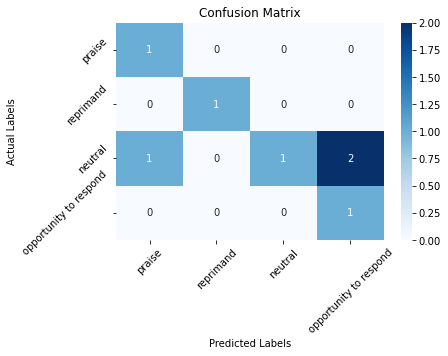

In [ ]:
sample_c_df, sample_class_report = get_performance_metrics(sample_results_df['truth'], sample_results_df['pred'],
                                                           label_nicknames, show_plots=True)

Let's see the contents of the resultant variables...

In [ ]:
sample_c_df

Predicted Labels,praise,reprimand,neutral,opportunity to respond
Actual Labels,,,,
praise,1,0,0,0
reprimand,0,1,0,0
neutral,1,0,1,2
opportunity to respond,0,0,0,1


In [ ]:
sample_class_report

,praise,reprimand,neutral,opportunity to respond,accuracy,macro avg,weighted avg
precision,0.500000,1.0,1.00,0.333333,0.571429,0.708333,0.833333
recall,1.000000,1.0,0.25,1.000000,0.571429,0.812500,0.571429
f1-score,0.666667,1.0,0.40,0.500000,0.571429,0.641667,0.538095
support,1.000000,1.0,4.00,1.000000,0.571429,7.000000,7.000000


Fantastic!  Looks like everything is working as expected!

---
# A brief aside on a code trick above...
The functions above use a `zip` trick which is new to this notebook (beyond the 60 series) so explained here.

For simplicity in the following functions, we pass in a dictionary of the labels with anything we want to rename the labels with, e.g., 
```
label_nicknames = {'PRS': 'praise',
                   'REP': 'reprimand',
                   'NEU': 'neutral',
                   'OTR': 'opportunity to respond'}
```
The keys of the dictionary are the real labels (data labels), and the values are the "nicknames" we want to give them, or what we use as "candidate labels" in zero-shot classification. We can get a list of data labels (keys) and nicknames (values) as individual lists as seen below.

The `items()` method gives us key-value pairs, and the `*` with `zip` performs element-wise aggregation across all inputs. It the items below, it takes the first element of the 4 pairs and puts them into a list, and takes the second element of the 4 pairs and puts them into a list.

In [ ]:
label_nicknames.items()

dict_items([('PRS', 'praise'), ('REP', 'reprimand'), ('NEU', 'neutral'), ('OTR', 'opportunity to respond')])

In [ ]:
list(zip(*label_nicknames.items()))

[('PRS', 'REP', 'NEU', 'OTR'),
 ('praise', 'reprimand', 'neutral', 'opportunity to respond')]

We use the list comprehension to convert each element from a tuple to a list.  Note that we don't use the simple 
```
list(dict(zip(*labels_lookup.items())))
```
syntax because this will return tuples.  We need lists because we use them as individual column selectors with pandas. If we left them as tuples, pandas would interpret this as a multiindex (essentially subcategories of each other) rather than individual columns.

In [ ]:
dog, cat = [list(a) for a in zip(*label_nicknames.items())]
print(dog)
cat

['PRS', 'REP', 'NEU', 'OTR']


['praise', 'reprimand', 'neutral', 'opportunity to respond']